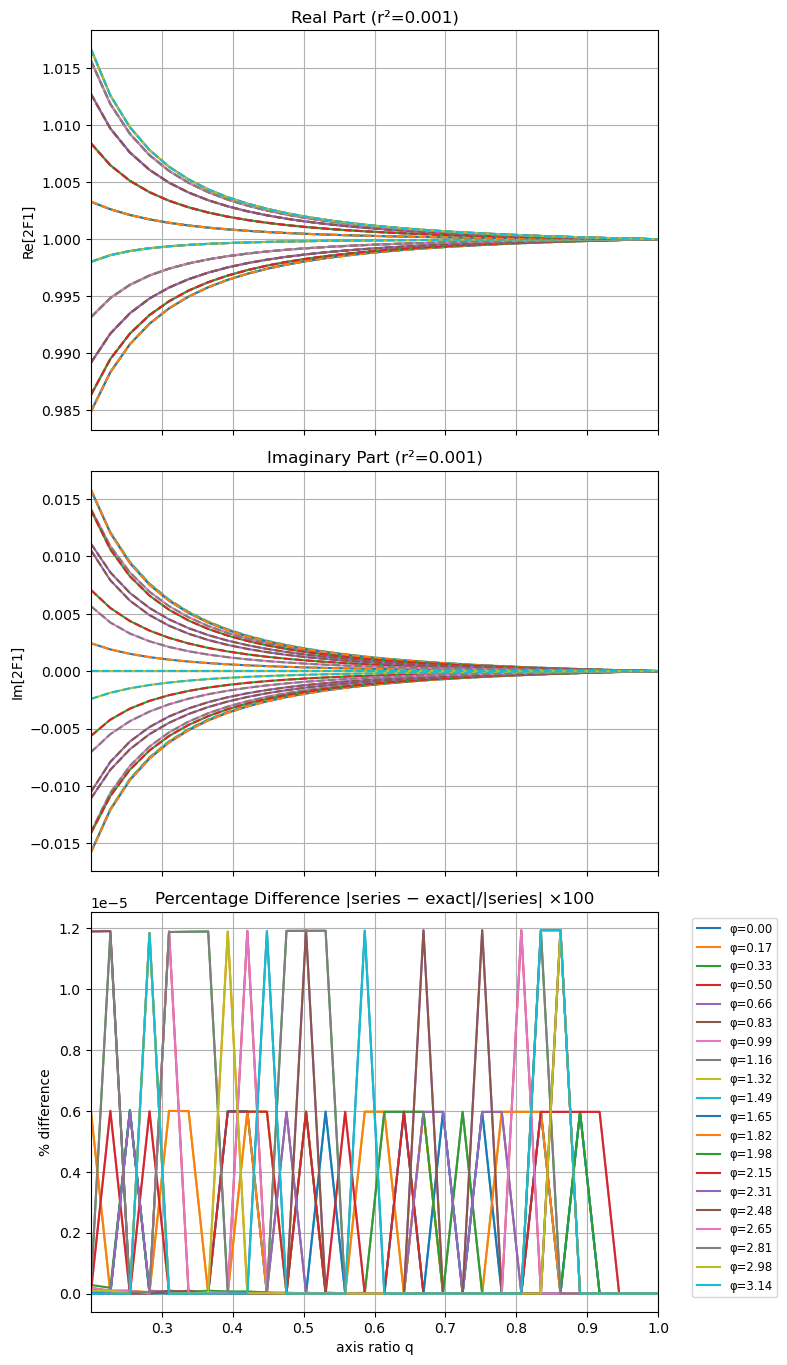

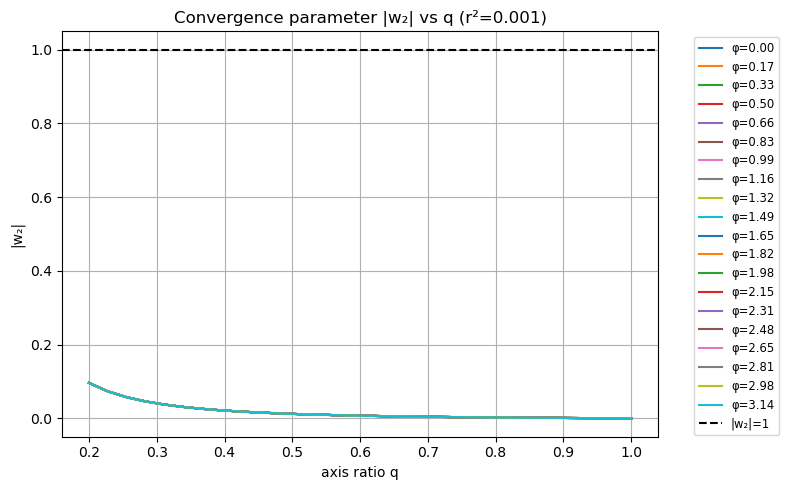

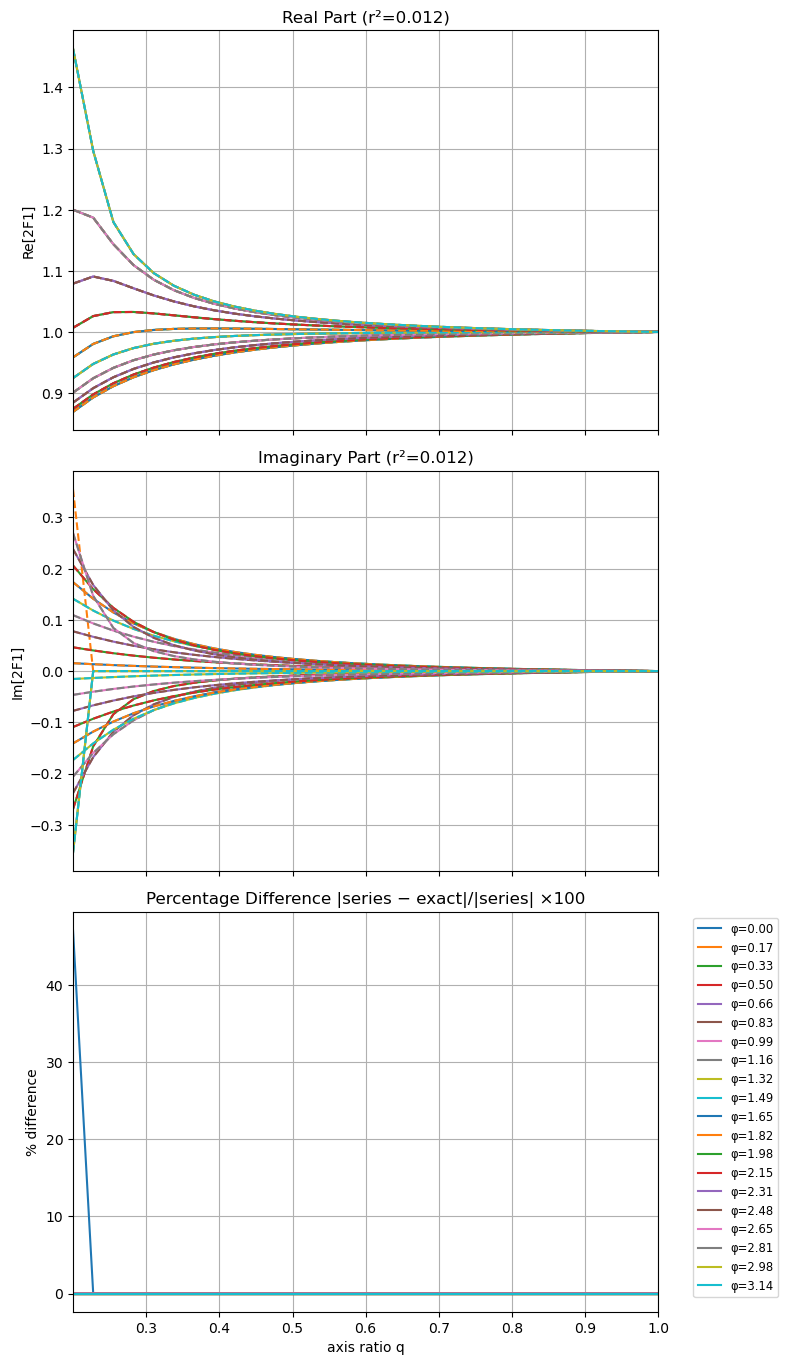

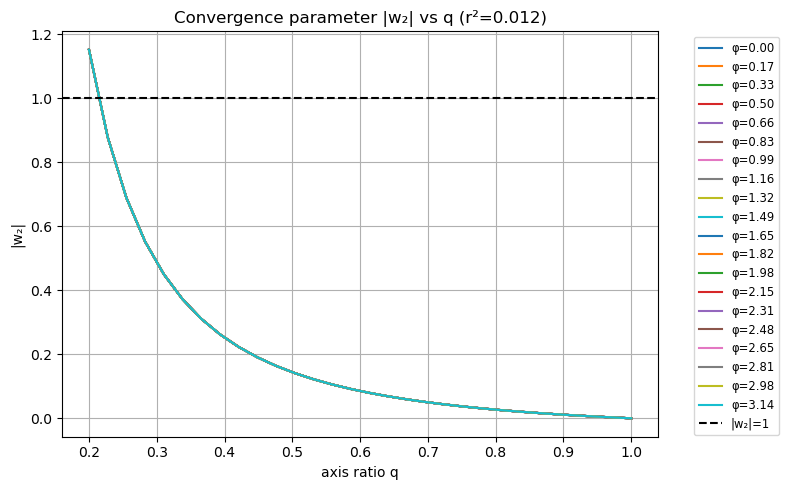

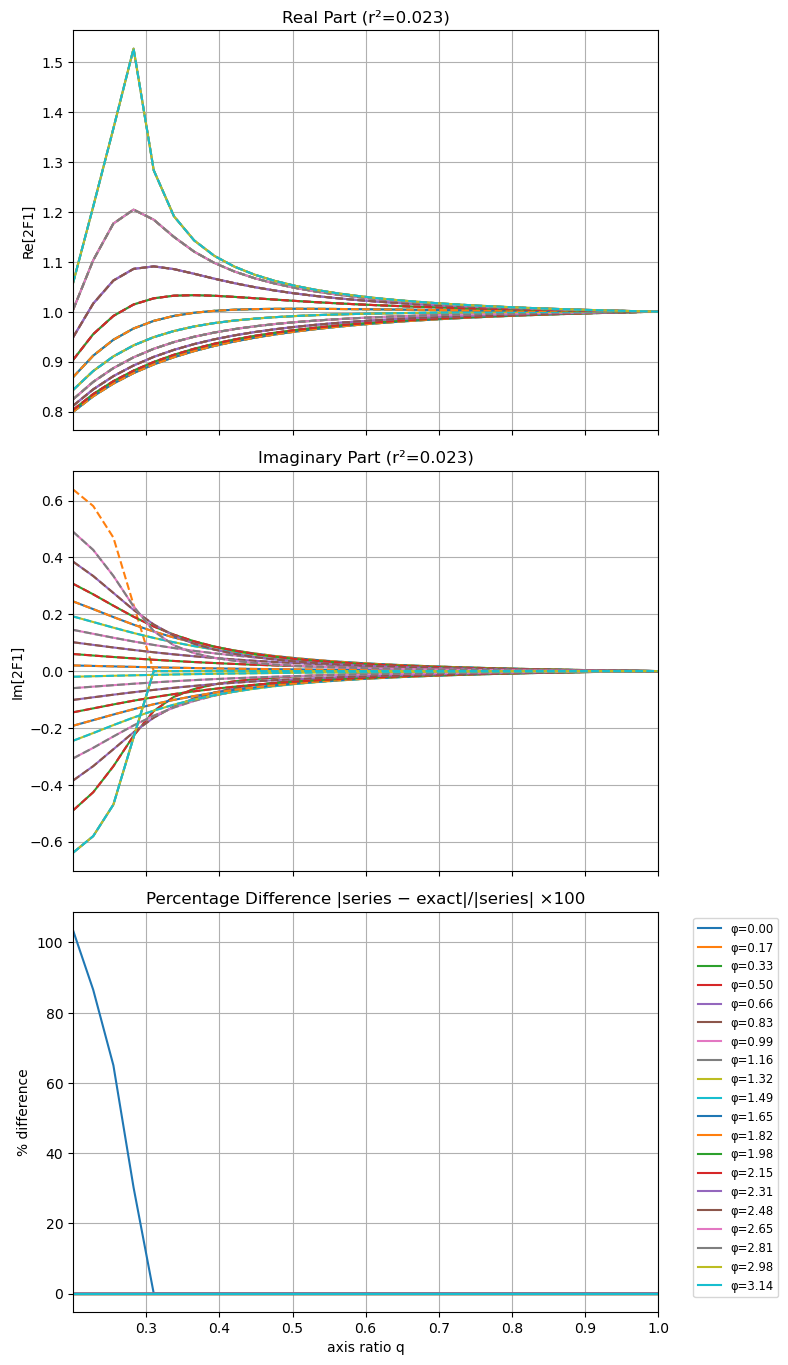

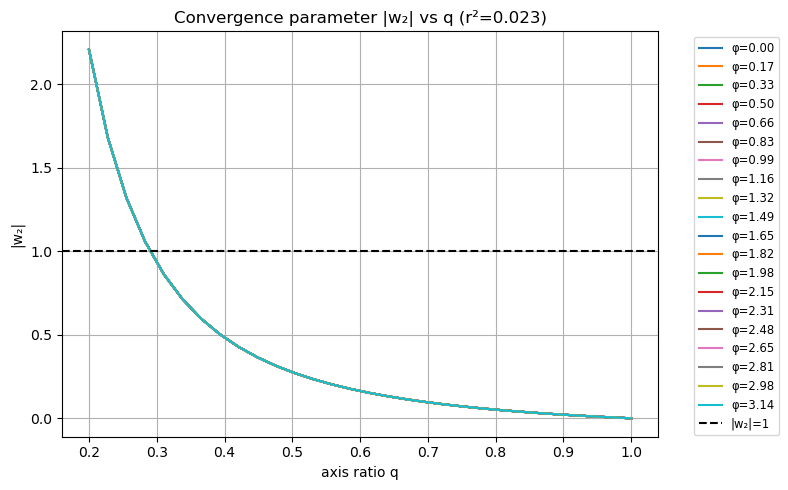

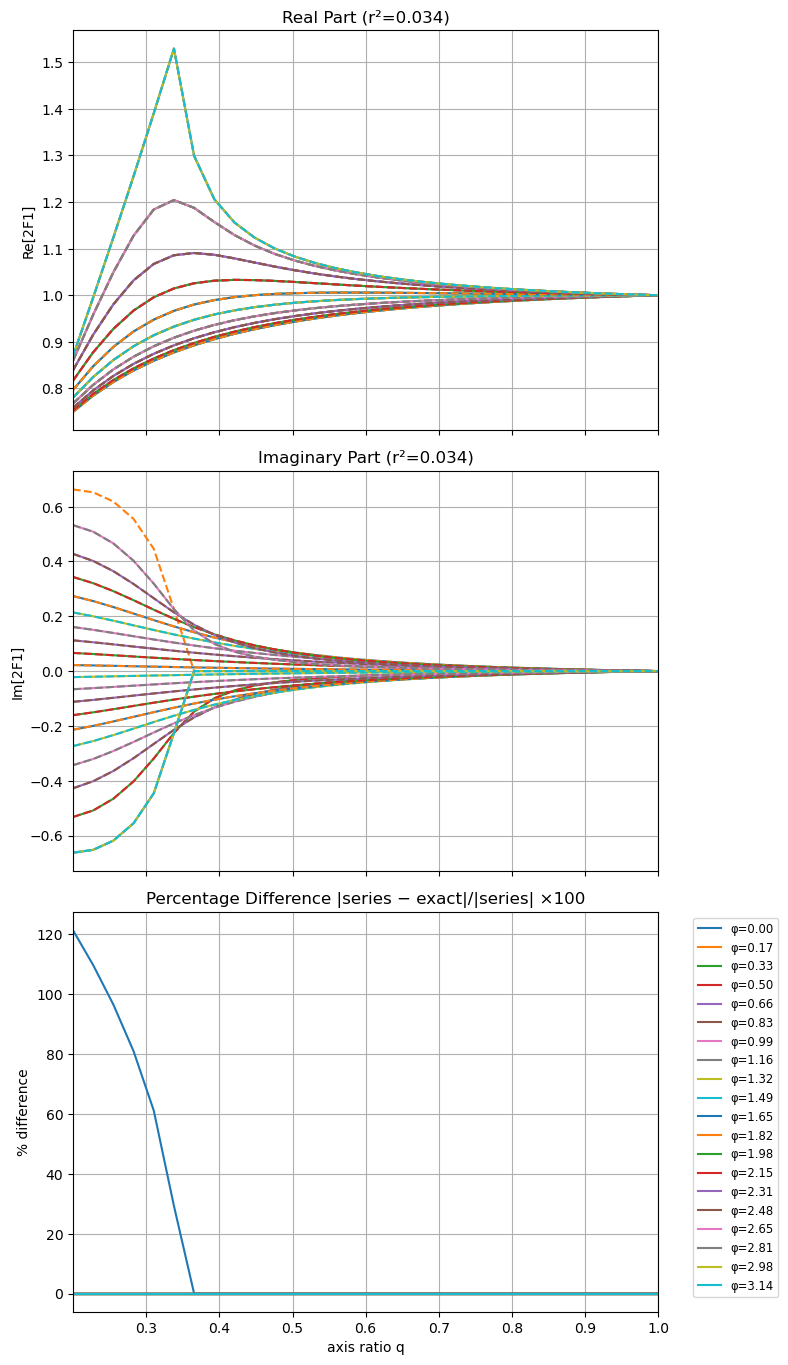

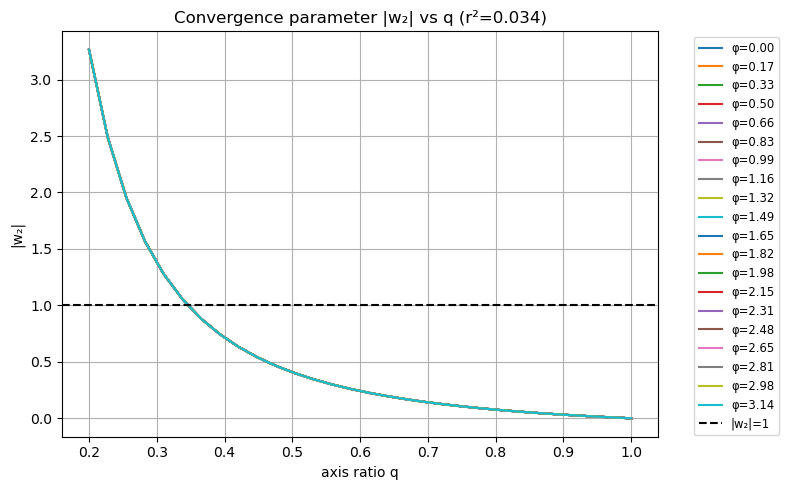

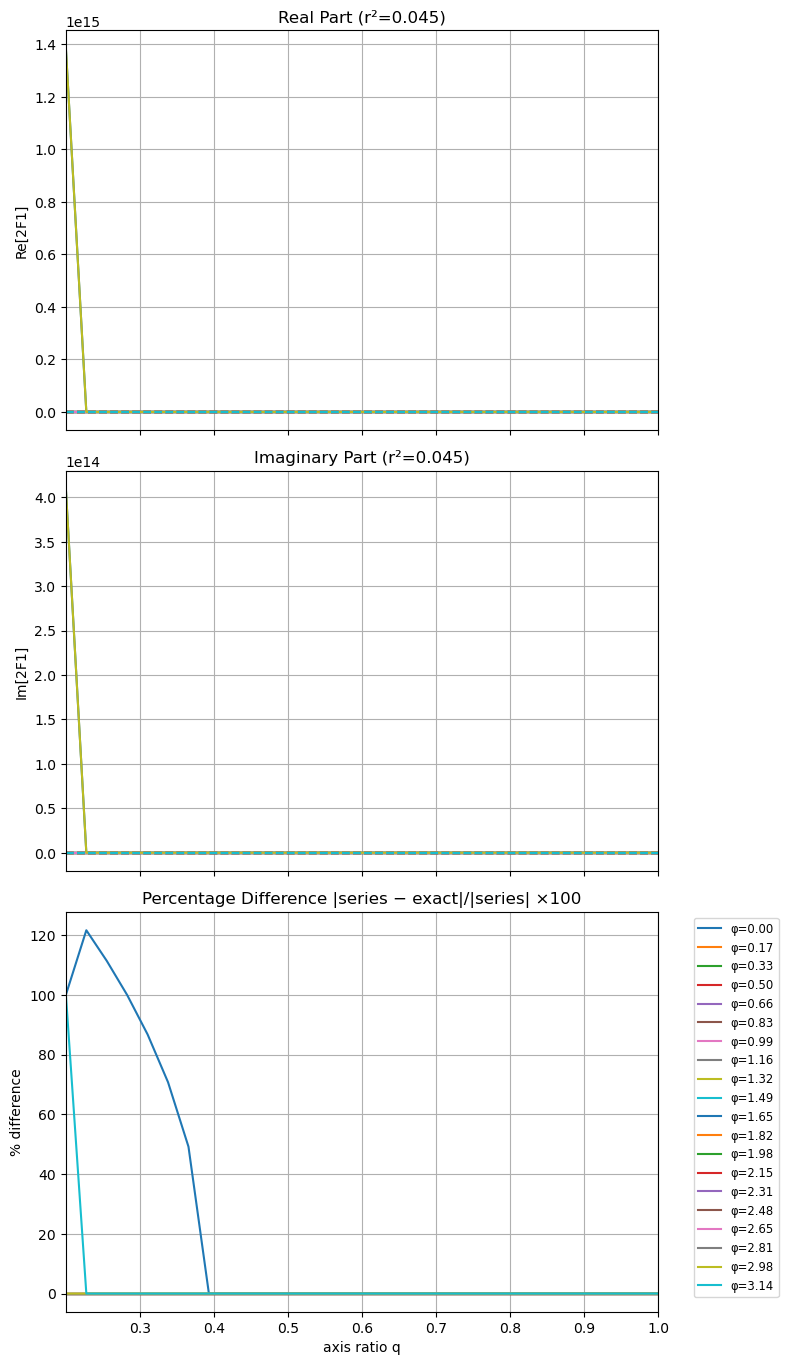

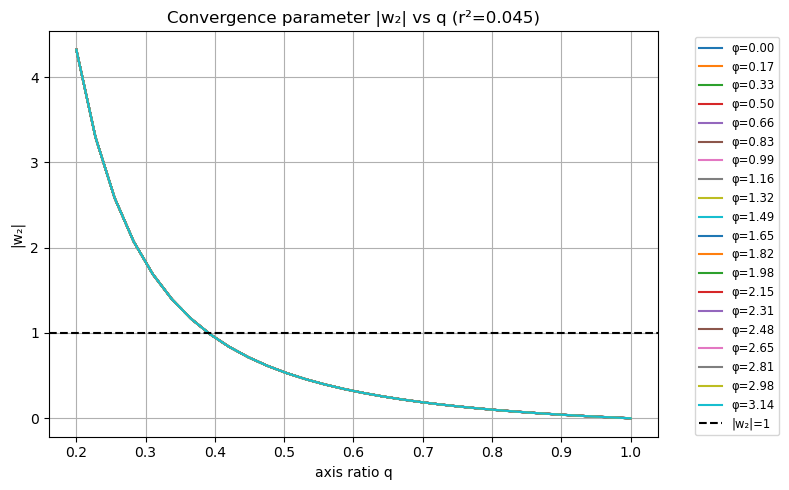

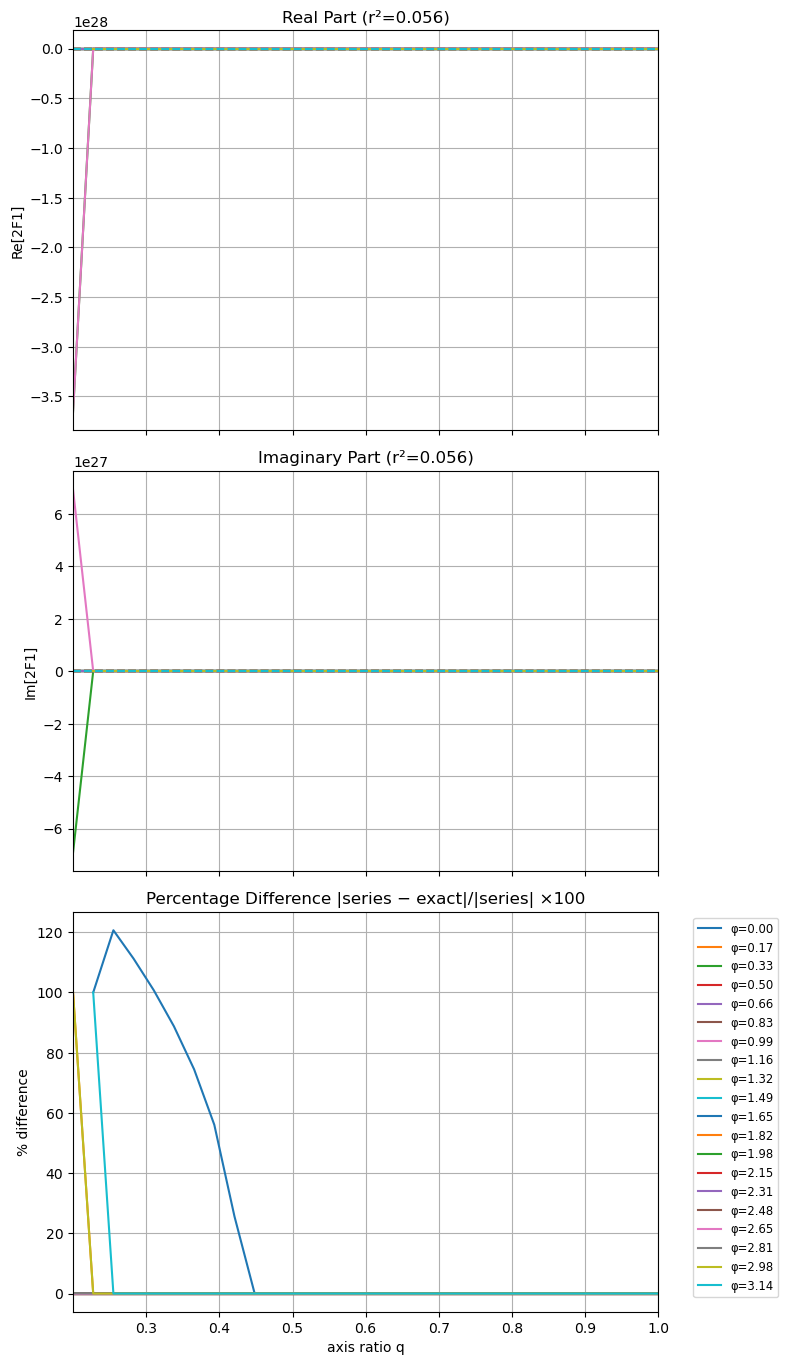

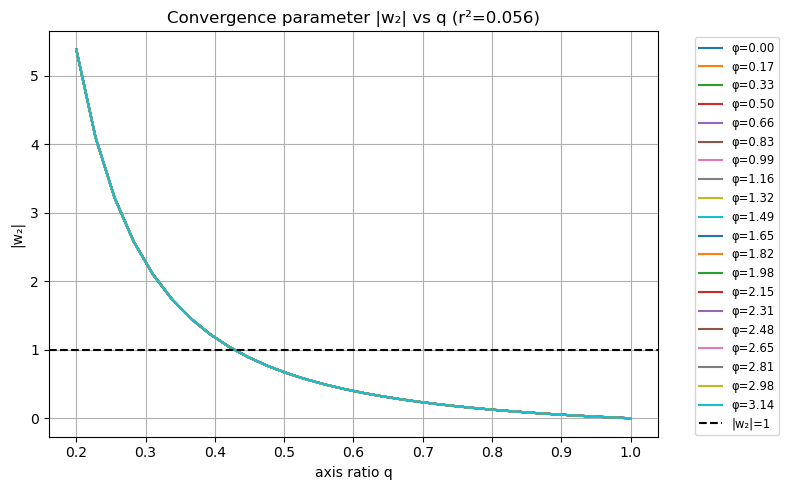

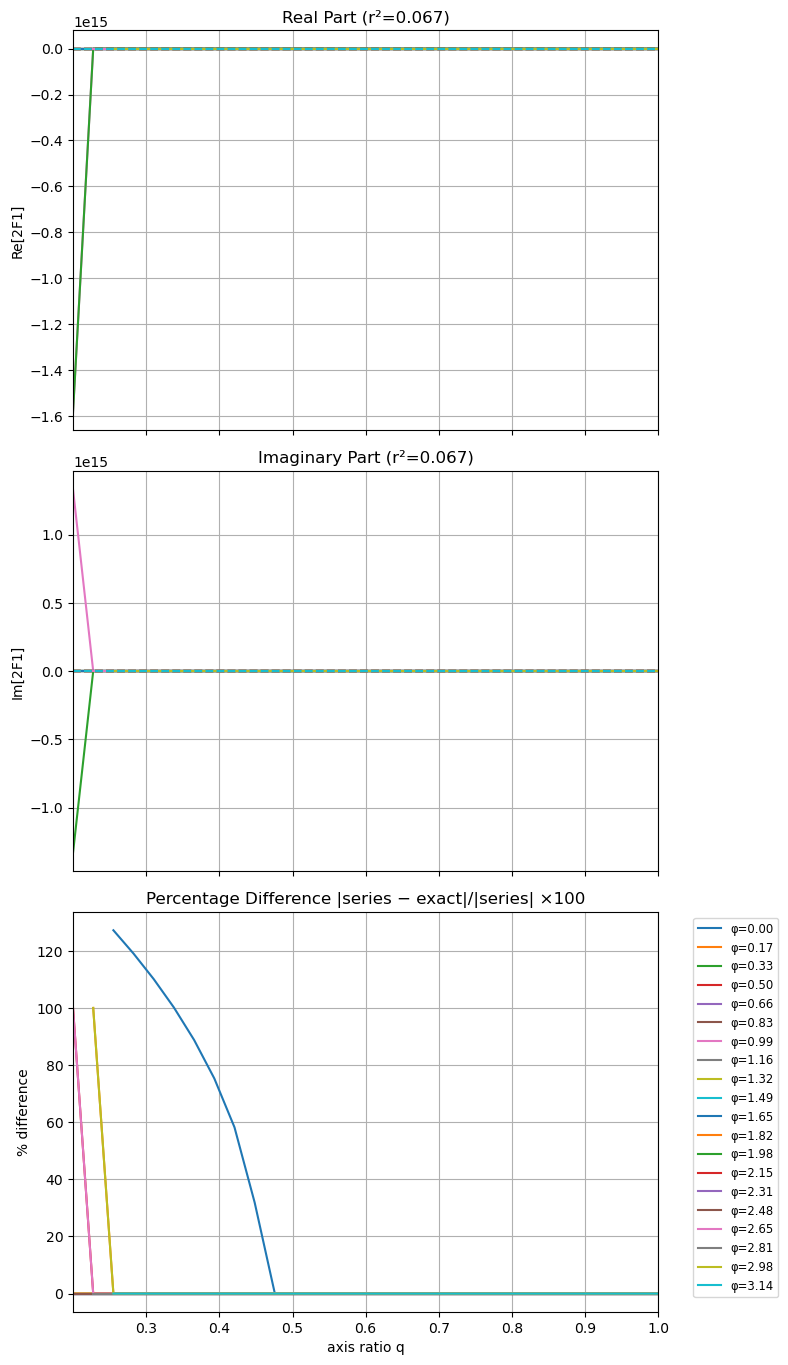

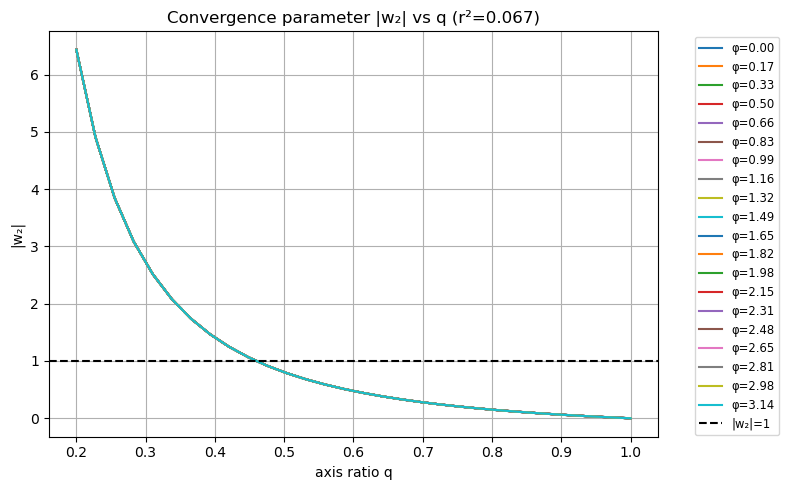

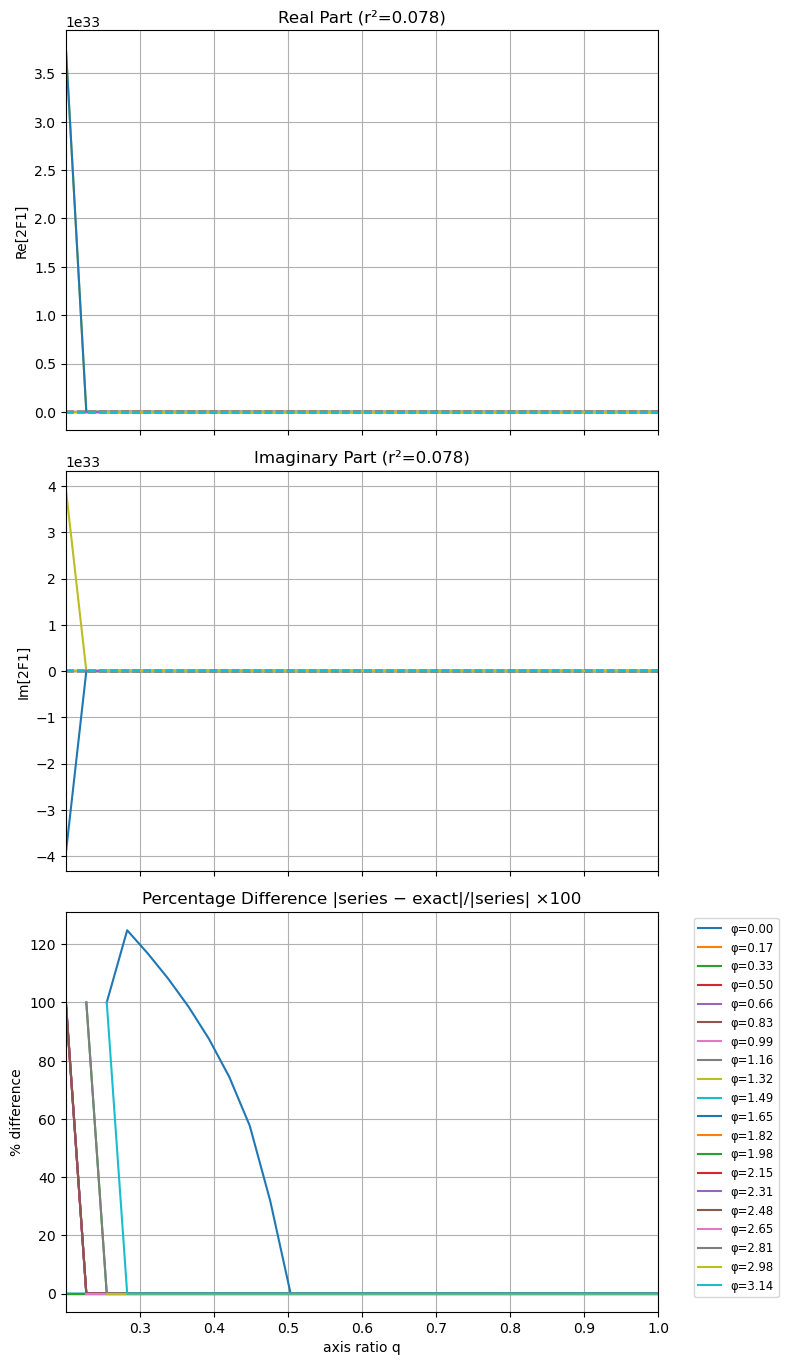

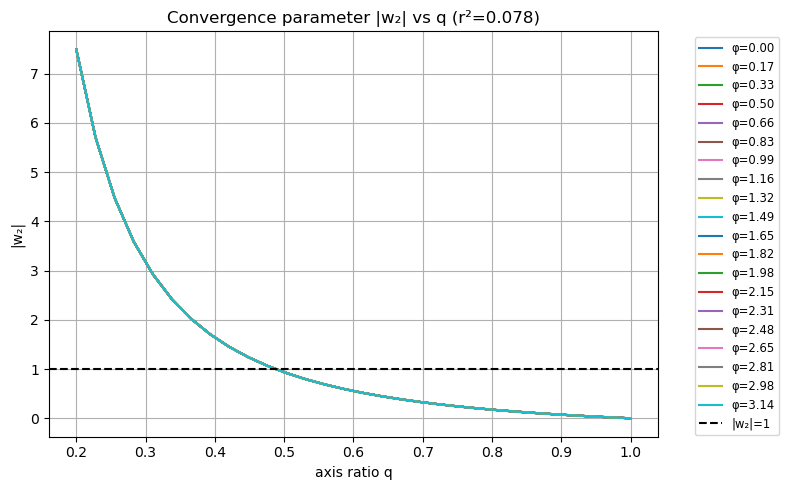

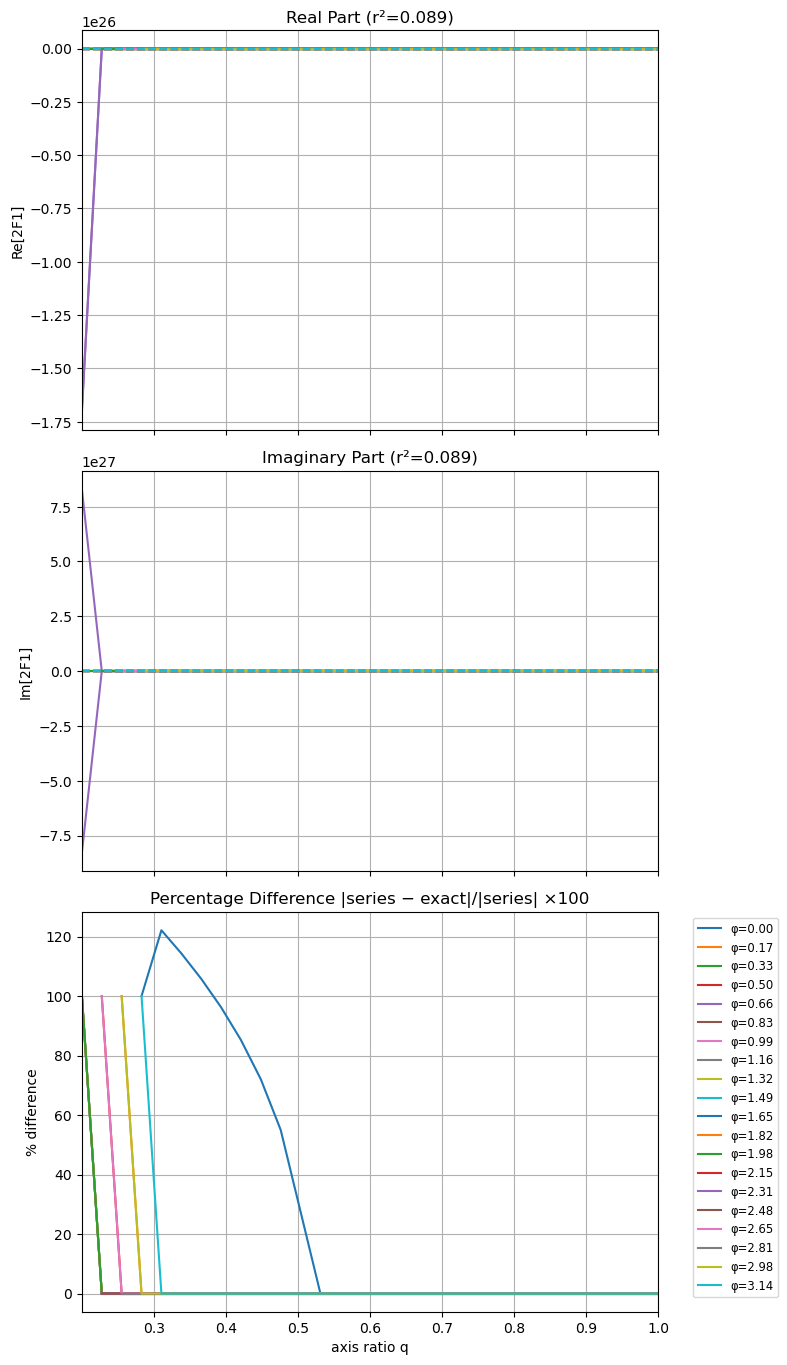

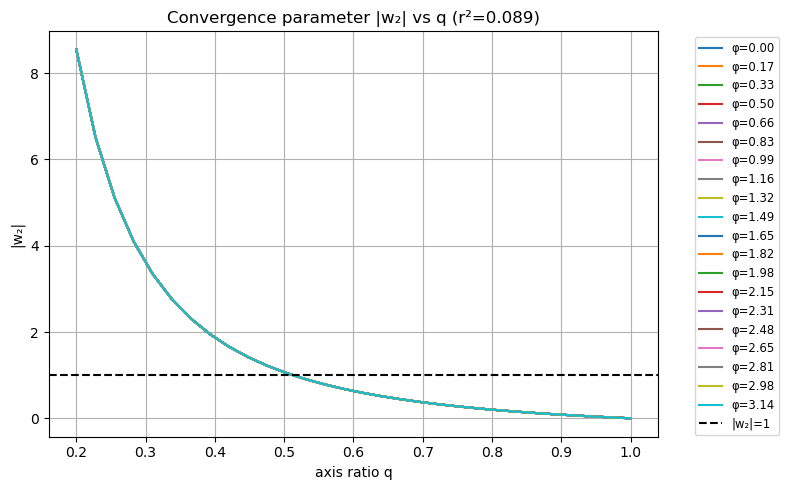

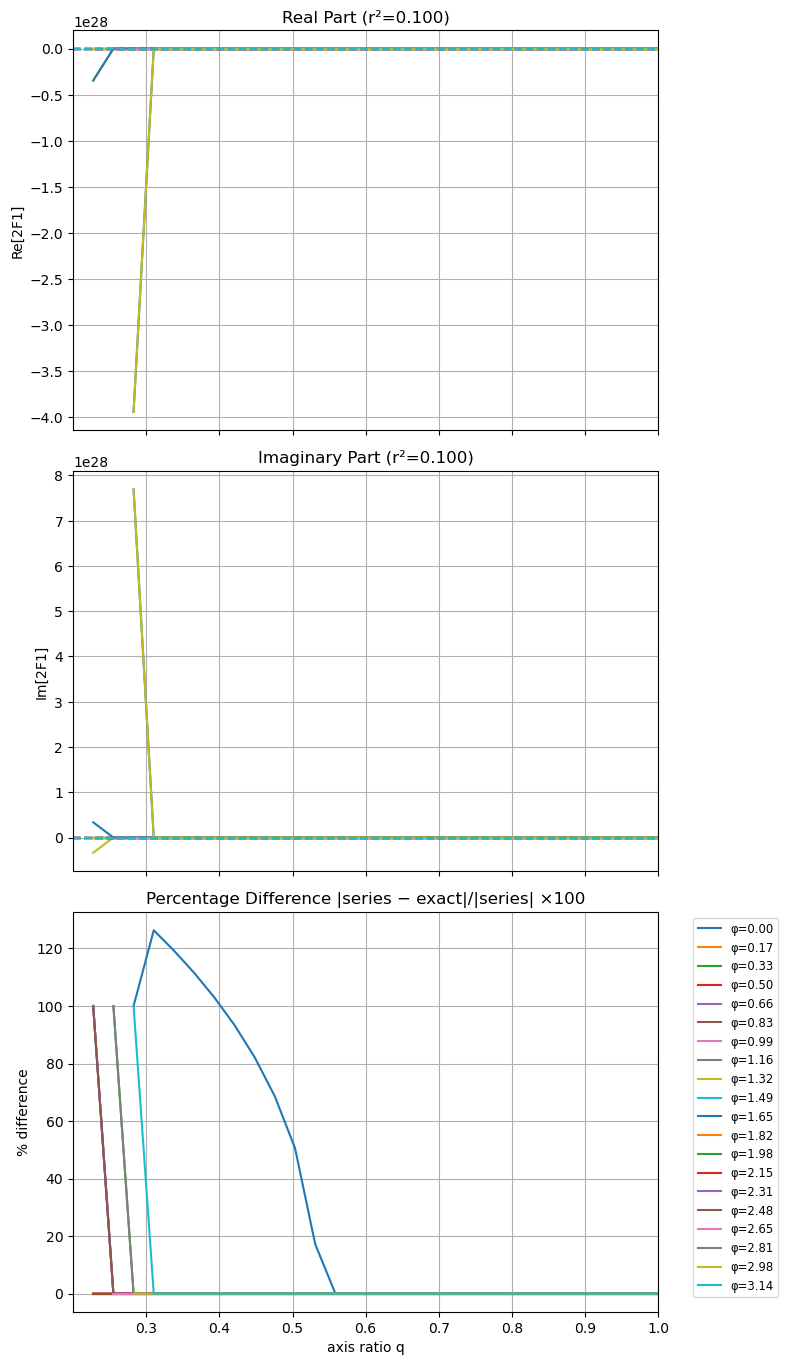

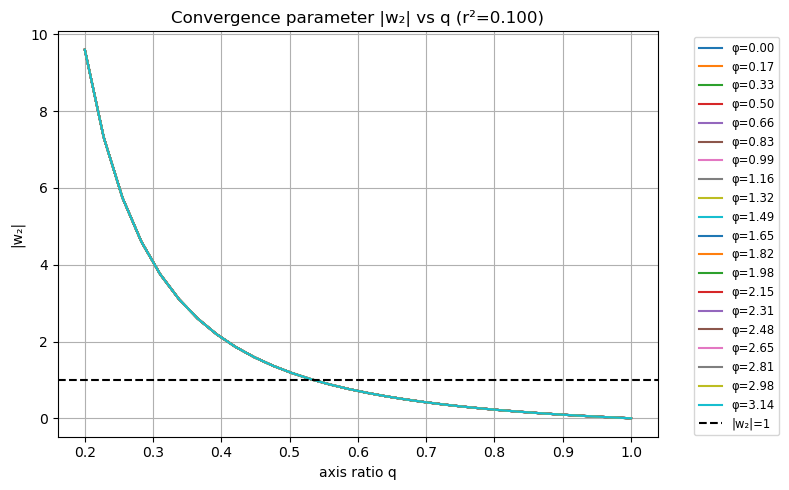

In [2]:
import torch
import numpy as np
from scipy.special import hyp2f1
import matplotlib.pyplot as plt
from lensing_system_broadcasting.lens_mass_components.util import _hyp2f1_series

# Parameters
r2_vals   = torch.linspace(0.001, 0.1, 10)  # different elliptical‐radius² values
t         = 1.0                            # power‐law slope
max_terms = 1000                           # number of series terms

# Build 1D arrays of q (axis ratio) and φ (angle), then 2D grids for broadcasting
q   = torch.linspace(0.2, 1.0, 30)          # 30 q-values from 0.2 to 1.0
phi = torch.linspace(0, torch.pi, 20)       # 20 φ-values from 0 to π
z   = 0.5 * torch.exp(1j * phi)             # 20 complex points at radius=0.5
q2d = q.unsqueeze(1)                        # shape [30,1]
z2d = z.unsqueeze(0)                        # shape [1,20]

for r2 in r2_vals:
    # 1) Series approximation [30×20]
    series = _hyp2f1_series(
        z=z2d, 
        r2=r2, 
        t=t, 
        q=q2d, 
        max_terms=max_terms
    ).cpu().numpy()
    
    # 2) “Exact” SciPy 2F1 [30×20]
    q_np = q2d.numpy()    # [30,1]
    z_np = z2d.numpy()    # [1,20]
    w2   = ((1 - q_np**2) / q_np**2) * r2.item() / (z_np**2)
    exact = hyp2f1(0.5, 1 - t/2, 2 - t/2, w2)
    
    # 3) Percentage difference |series – exact| / |series| ×100
    pct_diff = np.abs(series - exact) / (np.abs(series) + 1e-16) * 100.0

    # 4) Plot real part, imaginary part, and percent‐diff
    fig, (ax_re, ax_im, ax_pd) = plt.subplots(3, 1, 
                                              figsize=(8, 14), 
                                              sharex=True)
    for i, φ in enumerate(phi.numpy()):
        q_vals = q.numpy()
        # Real parts
        ax_re.plot(q_vals, series[:, i].real,      label=f"series φ={φ:.2f}")
        ax_re.plot(q_vals, exact[:, i].real,   '--', label=f"SciPy φ={φ:.2f}")
        # Imag parts
        ax_im.plot(q_vals, series[:, i].imag,      label=f"series φ={φ:.2f}")
        ax_im.plot(q_vals, exact[:, i].imag,   '--', label=f"SciPy φ={φ:.2f}")
        # Percent‐diff
        ax_pd.plot(q_vals, pct_diff[:, i],           label=f"φ={φ:.2f}")

    # Real subplot
    ax_re.set_ylabel("Re[2F1]")
    ax_re.set_title(f"Real Part (r²={r2:.3f})")
    ax_re.grid(True)
    ax_re.set_xlim(q_vals.min(), q_vals.max())
    #ax_re.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')

    # Imag subplot
    ax_im.set_ylabel("Im[2F1]")
    ax_im.set_title(f"Imaginary Part (r²={r2:.3f})")
    ax_im.grid(True)
    ax_im.set_xlim(q_vals.min(), q_vals.max())
    #ax_im.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')

    # Percent‐diff subplot
    ax_pd.set_xlabel("axis ratio q")
    ax_pd.set_ylabel("% difference")
    ax_pd.set_title("Percentage Difference |series − exact|/|series| ×100")
    ax_pd.grid(True)
    ax_pd.set_xlim(q_vals.min(), q_vals.max())
    ax_pd.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')

    plt.tight_layout()
    plt.show()

    # 5) Plot |w2| for all φ on one figure
    w2_mag = np.abs(w2)  # [30×20]
    plt.figure(figsize=(8,5))
    for i, φ in enumerate(phi.numpy()):
        plt.plot(q_vals, w2_mag[:, i], label=f"φ={φ:.2f}")
    plt.axhline(1.0, color='k', linestyle='--', label="|w₂|=1")
    plt.xlabel("axis ratio q")
    plt.ylabel("|w₂|")
    plt.title(f"Convergence parameter |w₂| vs q (r²={r2:.3f})")
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
